In [1]:
import pathlib
import os
from glob import glob

import h5py
import pandas as pd
import json
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt
import dask.array as da
import dask.dataframe as dd
import skimage 
import cloudpickle

import sklearn
from sklearn.linear_model import LinearRegression as LinReg


import SessionTools.two_photon as st2p
# from SessionTools.two_photon import utilities
from SessionTools.utilities import *


import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['font.size'] = 18
matplotlib.rcParams['pdf.use14corefonts']=True
# matplotlib.rc('font', family='arial')



%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [22]:
date = "07_07_2023"
genotype = "EPG_jGCaMP7f_CsChrimsontdT"
fly = "fly2"
session = 'open_loop_post_atp-002'
# basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{genotype}/{fly}/{session}/')
basedir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2PData/{date}/{genotype}_{fly}/{session}/')
basename_input = pathlib.Path(basedir.joinpath(session))
metadata = st2p.preprocessing.bruker_metadata.read(basename_input)

# h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{genotype}/{fly}/{session}/data.h5'
h5name = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{genotype}_{fly}/{session}/data.h5'
if not os.path.exists(h5name):
    tiff_data = st2p.preprocessing.tiff_tools.read(basename_input, 
                                            metadata['size'],metadata['layout'], first_chan=1)
    st2p.preprocessing.tiff_tools.convert_to_hdf5(tiff_data,h5name, overwrite=True)
    
figdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/fig_scratch/EL_meeting/antibump/{date}/{genotype}_{fly}/{session}/')
os.makedirs(figdir, exist_ok=True)

In [23]:
f = h5py.File(h5name)
data = f['/data'][:]

ref_img = st2p.preprocessing.motion_correction.make_ref_img(data,0)
data_corr, shifts, error, diffphase = st2p.preprocessing.motion_correction.align_data_chunk(data, ref_img[0,:,:,:], in_place=False)

# napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{genotype}/{fly}/{session}/napari.pkl'
napari_outputs_file = f'/media/mplitt/SSD_storage/2P_scratch/{date}/{genotype}_{fly}/{session}/napari.pkl'


with open(napari_outputs_file, 'rb') as file:
    np_layers = cloudpickle.load(file)
masks = np_layers['rois']
background = np_layers['background']

In [24]:
# csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{genotype}/{fly}/{session}/*.csv')
csv_files = glob(f'/media/mplitt/SSD_storage/2PData/{date}/{genotype}_{fly}/{session}/*.csv')
vr_file = pathlib.Path(csv_files[0])
df = dd.read_csv(vr_file).compute()

In [25]:
frame_times = np.array(metadata['frame_times']).mean(axis=-1)*1000
df_aligned = st2p.preprocessing.signals.align_vr_2p(df,frame_times)

In [26]:
if background.ravel().sum()>0:
    F, notF = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks, 16, bckgnd_mask = background, max_proj=False)
else:
    F, notF = st2p.preprocessing.signals.extract_2p_timeseries(data_corr, masks, 16, bckgnd_mask = None, max_proj=False)
    
        


0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [27]:
# remove background
for ch in range(F.shape[0]):
    lr = LinReg().fit(notF[ch,np.newaxis, :].T, F[ch,:,:].T)
    F[ch,:,:] = F[ch,:,:]-1.*lr.predict(notF[ch,np.newaxis,:].T).T  + lr.intercept_[:,np.newaxis]


F = sp.ndimage.gaussian_filter1d(F,2,axis=-1)
F = sp.ndimage.gaussian_filter1d(F,1.5,axis=1, mode='wrap')



In [28]:
dff = sp.stats.zscore(F[0,:,:], axis=-1)


In [29]:
x_f,y_f = st2p.utilities.pol2cart(dff,np.linspace(-np.pi,np.pi,num=16)[:,np.newaxis])
pv_len,pv_ang = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))

_, heading = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones((df_aligned.shape[0],)), 
                                                           np.pi-1*df_aligned[' Heading'].to_numpy().ravel()))



_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),pv_ang-heading))

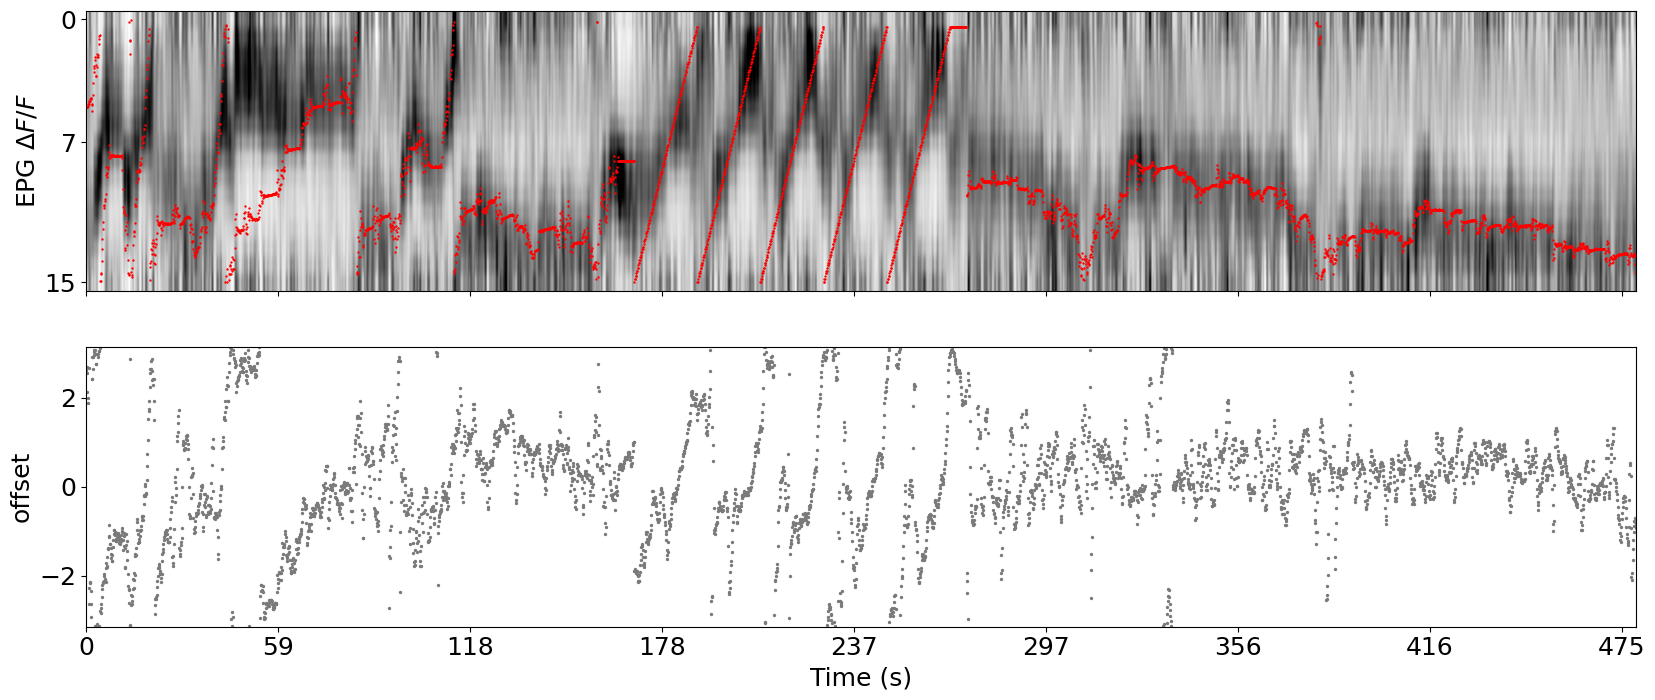

In [30]:
plt.rcParams.update({'font.size':18})

start, stop = 0, dff.shape[-1]

window = slice(start, stop)
x = np.arange(stop-start)
time = df_aligned['Time(ms)'].to_numpy()
time = time-time[0]
    
fig, ax = plt.subplots(2,1,figsize=[20,8], sharex=True)
dff_window = dff[:,window]
ax[0].imshow(dff_window,aspect='auto',cmap='Greys',vmin=-3,vmax=3)
ax[0].set_yticks([0,7,15])
ax[0].set_ylabel(r"EPG $  \Delta F/F$")


ax[0].scatter(x,15*(heading[window]+np.pi)/2/np.pi,color='red',marker='.',s=2)


ax[1].scatter(x,offset[window],s=2, color=plt.cm.Greys(.6))
ax[1].set_ylim([-3.14,3.14])
# # ax[1].plot(x,0*offset[window], marker='_')


ax[1].set_ylabel('offset')
ax[1].set_xlabel('Time (s)')

ax[1].set_xticks(x[::500], labels = [str(int(time[i]/1000)) for i in range(0,x[-1]+1,500)])

fig.savefig(figdir.joinpath('dff_w_offset.pdf'))


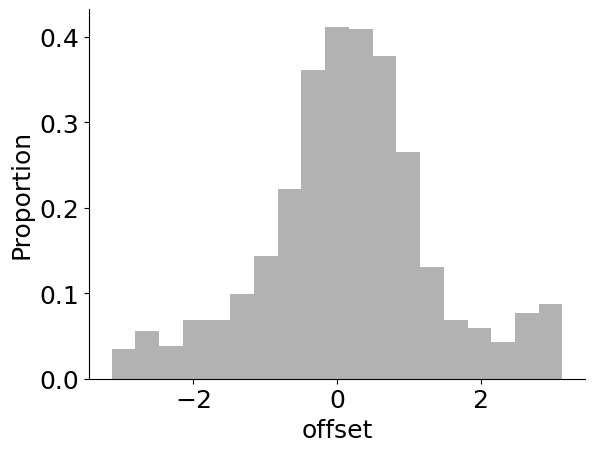

In [31]:
fig,ax = plt.subplots()
bin_edges=np.linspace(-np.pi,np.pi,num=20)


ax.hist(offset,bins = bin_edges, alpha=.3, color='black',density=True)
ax.set_xlabel('offset')
ax.set_ylabel('Proportion')

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

fig.savefig(figdir.joinpath('offset_hist.pdf'))